# CT Images Denoising - Synthetic Images

Description of the jupyter notebook and maybe brief overview of the all project.

**Authors:** [Raphaël Achddou](https://people.epfl.ch/raphael.achddou) ([contact](mailto:raphael.achddou@epfl.ch)), [Paulo Ribeiro](https://people.epfl.ch/paulo.ribeirodecarvalho) ([contact](mailto:paulo.ribeirodecarvalho@epfl.ch))

## Import
Let's first import all libraries needed for the production of synthetic images using dead leaves.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
import cv2

from helpers import *
from skimage import exposure

%load_ext autoreload
%autoreload 2

## Load Data

To create meaningful synthetic images, we made them statistically equivalent to real images. Then, samples of real CT images are needed.

In [2]:
#TODO: Still need to download all the images. Only downloaded a small batch (8Go of 150Go)
path_training = 'data/train/3mm B30'
path_qd = 'quarter_3mm/L506/quarter_3mm'
path_fd = 'full_3mm/L506/full_3mm'

l506_qd = load_data('/'.join([path_training, path_qd]))
l506_fd = load_data('/'.join([path_training, path_fd]))

We can now have a look at each patient and each projection of the training images.

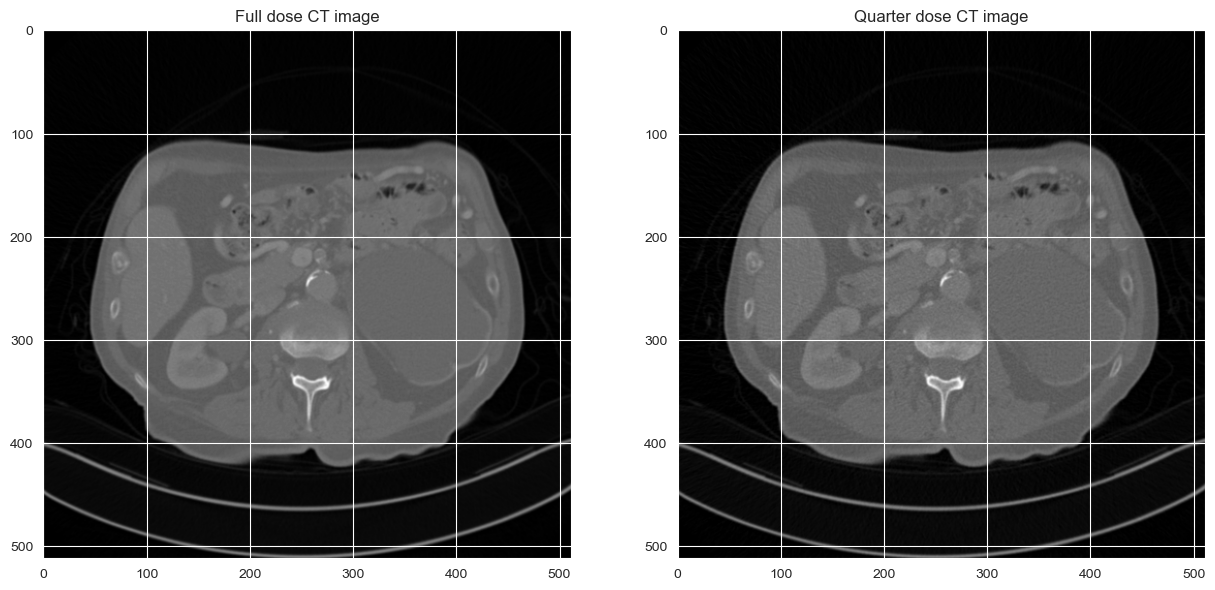

In [3]:
# Enhance the contrast of images ! But careful because might be performing a image processing step.
# exp_img = exposure.equalize_adapthist(pixel_img)

idx = 55  # select one of the 600 projection of patient L506

# Display the Ct images to have a quick overview
fig, axs = plt.subplots(1, 2, figsize=(15,15))

axs[0].imshow(l506_fd[idx], cmap='grey')
axs[0].set_title('Full dose CT image')
axs[1].imshow(l506_qd[idx], cmap='grey')
axs[1].set_title('Quarter dose CT image')

plt.show()

## Statistical Analysis

As mention above, a statistical analysis from the real CT images need to be done to replicate the statistics in our synthetic images. We will focus on these following stat metrics :

1) color distribution
2) morphological analysis
3) ...

### Color Distribution

Let's start by analyzing the color distribution of our real CT images. It is doing in a straightforward and easy manner by computing the histogram of the pixel intensities across all CT images from all patient.

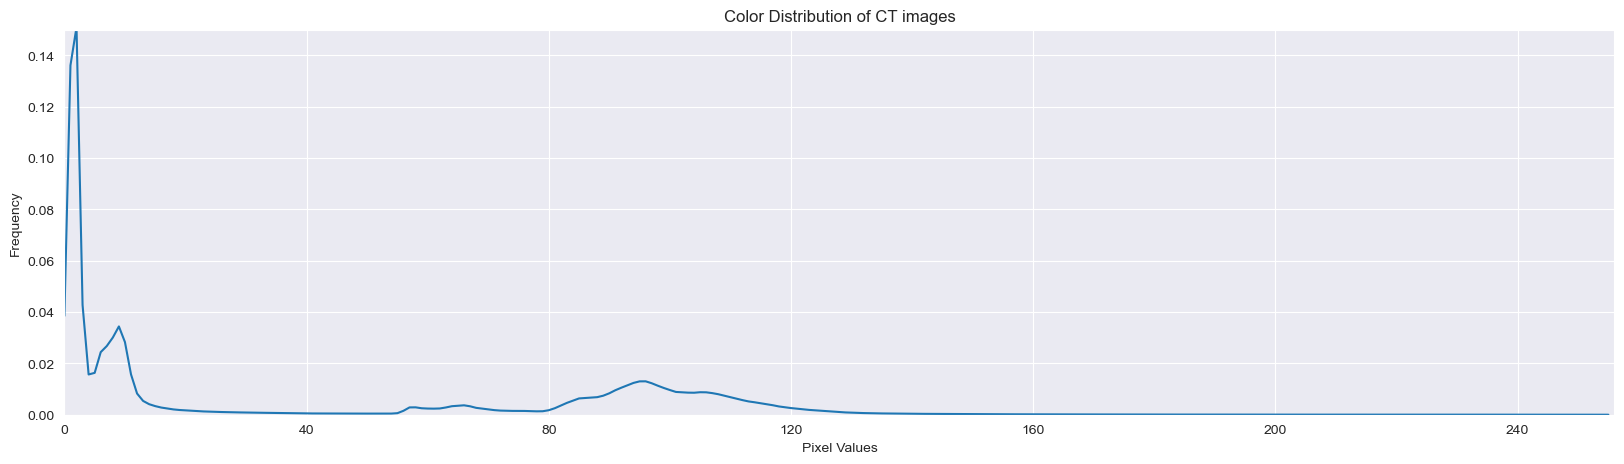

In [4]:
#TODO: Talk with Raphaël about which other metrics can be added

# Color distribution of full CT images
pixel_values, color_dist = color_distribution(l506_fd, plot=True)

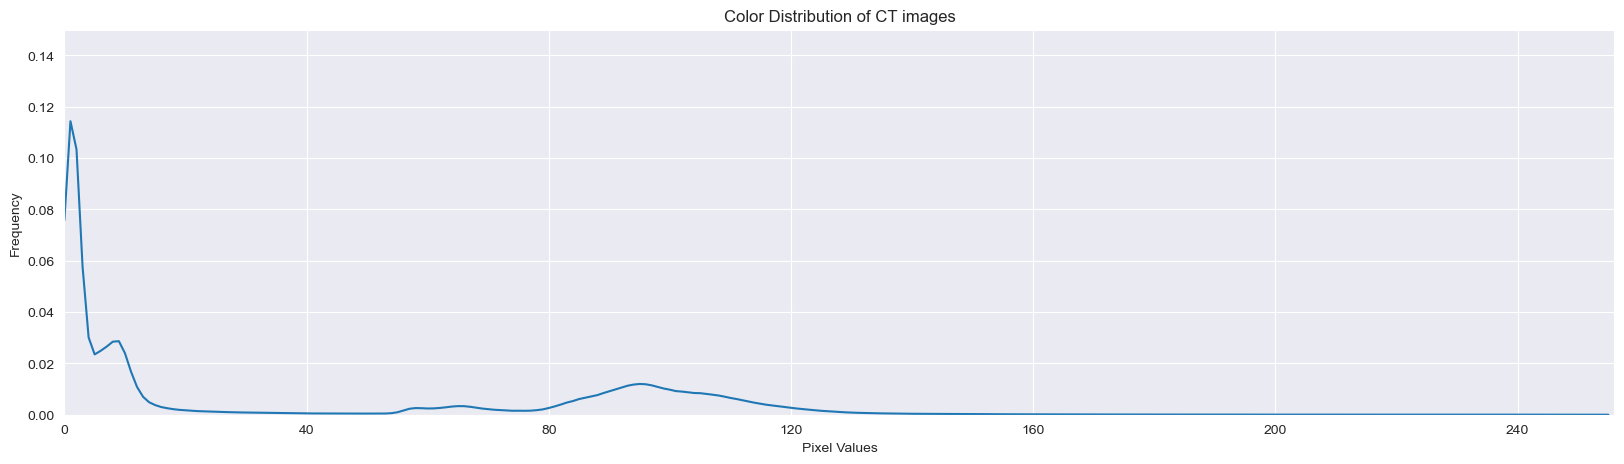

In [5]:
# Color distribution of quarter CT images
pixel_values, color_dist = color_distribution(l506_qd, plot=True)

### Morphological Analysis

We make sure that our synthetic images follows the same morphological pattern. We then analysis which object is better to use during dead leaves generation and also which size of the object is preferred.

#### Object to Use

Useful documentation for [morphological](https://scikit-image.org/docs/stable/auto_examples/applications/plot_morphology.html#sphx-glr-auto-examples-applications-plot-morphology-py) analysis, fourier transform, ...

To do so, compute some erosion and dilation images using different object (circle, square, line, ...) and compare them to the original image. The most similar transformed image will give us which object to use.

In [6]:
# TODO

#### Size of Object

To have this information, few ways are possible.

1) Directional Gradient Histogram
2) Fourier Transformation

##### 1) Directional Gradient Histogram

Here we basically compute the difference between each neighbour pixels (for each direction) and compute its histogram. Then we try to fit a Laplace distribution on it.

$e^{-\alpha|x|}$

This way, we find hthe $\alpha$ value that will give us information on the size of the object to use.

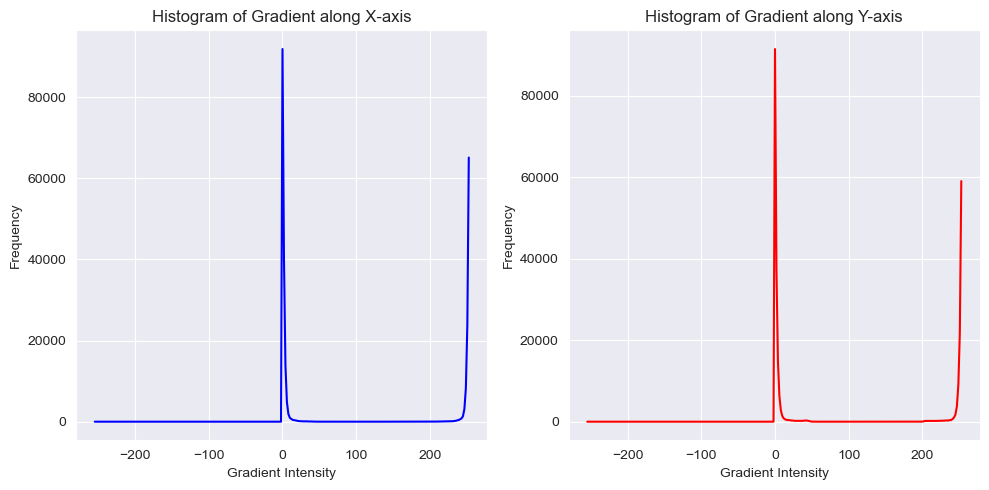

In [7]:
# Compute gradients along x-axis and y-axis
gradient_x = np.diff(l506_qd[55], axis=1)
gradient_y = np.diff(l506_qd[55], axis=0)

# Flatten the gradient arrays to compute histograms
gradient_x_flat = gradient_x.flatten()
gradient_y_flat = gradient_y.flatten()

# Compute histograms
hist_x, bins_x = np.histogram(gradient_x_flat, bins=256, range=(-255, 255))
hist_y, bins_y = np.histogram(gradient_y_flat, bins=256, range=(-255, 255))

# Plot histograms
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(bins_x[:-1], hist_x, color='blue')
plt.title('Histogram of Gradient along X-axis')
plt.xlabel('Gradient Intensity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.plot(bins_y[:-1], hist_y, color='red')
plt.title('Histogram of Gradient along Y-axis')
plt.xlabel('Gradient Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

##### 2) Fourier Transformation

Compute the Fourier transform of images and look at the y and x-axis (middle to positive) of this 3D graph (2D for the image dimension and the third with the fourier value at this point). The slope of the log plot will be interesting. Don't know why at the moment.

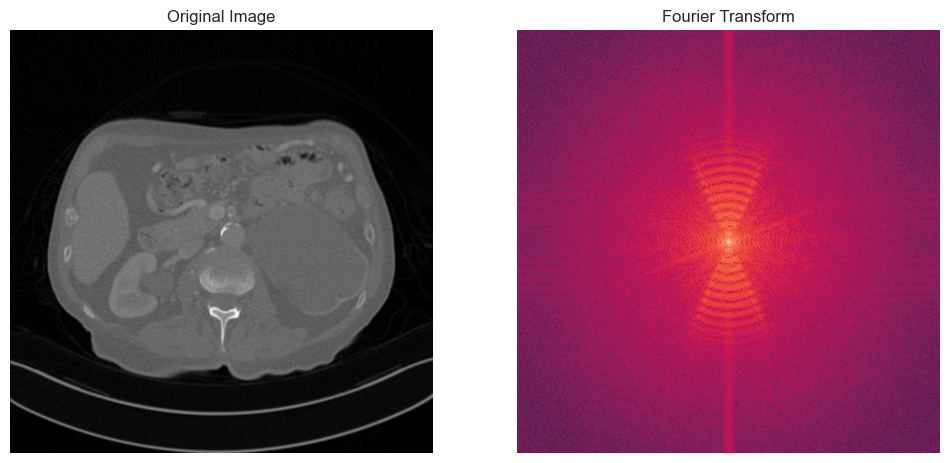

In [8]:
from scipy.fft import fft2, fftshift

# Compute the 2-dimensional Fourier transform
f_transform = fft2(l506_qd[55])

# Shift the zero frequency component to the center of the spectrum
f_transform_shifted = fftshift(f_transform)

# Compute the magnitude spectrum (absolute value)
magnitude_spectrum = np.abs(f_transform_shifted)

# Display the original image and its Fourier transform
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(l506_qd[55], cmap='gray')
plt.title('Original Image'), plt.axis('off')
plt.subplot(122), plt.imshow(np.log(1 + magnitude_spectrum))
plt.title('Fourier Transform'), plt.axis('off')
plt.show()

/var/folders/tn/31pmfl0n667ghvsfkxf6nxyh0000gn/T/ipykernel_40434/973840510.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(np.arange(0,256)), np.log(f_transform_shifted[256][256:]))
/opt/anaconda3/envs/deep_learning/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/deep_learning/lib/python3.10/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


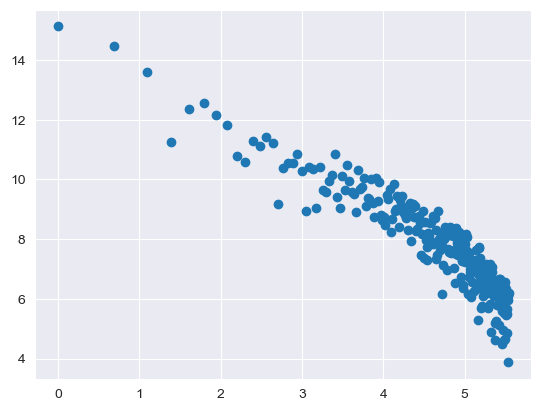

In [9]:
plt.scatter(np.log(np.arange(0,256)), np.log(f_transform_shifted[256][256:]))

## Synthetic Images Generation

Now, let's compute our synthetic images using our knowledge from the real CT images.

In [10]:
#TODO: Talk about how many

## Noise Statistical Analysis

Use the full and quarter dose projection, respectively FD and QD, to empirically compute the noise distribution. This way, we will be able to add some noise on our synthetic images to be able to train our model later on.

In [11]:
#TODO: Compute the noise distribution observed on our sample of CT real images